In [1]:
import os

import torch
import pytorch_lightning as pl
print('torch version: ', torch.__version__)
cuda_no = "cuda:6"
device = torch.device(cuda_no if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
print(device)

from hydra.experimental import initialize, compose
from hydra.utils import instantiate

torch version:  1.8.1+cu102
cuda:6


In [2]:
import numpy as np
import time 
import matplotlib.pyplot as plt
%matplotlib inline

from einops import rearrange

In [3]:
from bliss import sleep
from bliss.datasets import simulated, sdss

from bliss.models.location_encoder import (
    get_full_params_from_tiles,
    get_images_in_tiles,
    subtract_bg_and_log_transform,
)

torch.manual_seed(45245)
np.random.seed(3453)

In [4]:
import sys
sys.path.append('../starnet_utils/')
import plotting


# config

In [5]:
###################
# load config parameters 
###################
with initialize(config_path='./'):
    cfg = compose("defaults")
    
       
print('config: ')
print(cfg)


config: 
{'mode': 'train', 'gpus': 1, 'paths': {'root': None, 'output': '${paths.root}/output', 'sdss': '${paths.root}/data/sdss', 'data': '${paths.root}/data'}, 'datasets': {'simulated_m2': {'_target_': 'bliss.datasets.simulated.SimulatedDataset', 'prior': '${models.prior}', 'decoder': '${models.decoder}', 'background': [667.0], 'n_batches': 40, 'batch_size': 64, 'generate_device': 'cuda:6', 'testing_file': None}}, 'models': {'decoder': {'_target_': 'bliss.models.decoder.ImageDecoder', 'n_bands': 1, 'tile_slen': 10, 'ptile_slen': 30, 'border_padding': 5, 'psf_params_file': '../decaps/psf/iband_psf_gauss.npy', 'sdss_bands': [2]}, 'encoder': {'_target_': 'bliss.models.location_encoder.LocationEncoder', 'n_bands': '${models.decoder.n_bands}', 'tile_slen': '${models.decoder.tile_slen}', 'ptile_slen': 20, 'max_detections': 2, 'channel': 17, 'spatial_dropout': 0.11399, 'dropout': 0.013123, 'hidden': 185}, 'prior': {'_target_': 'bliss.models.prior.ImagePrior', 'n_bands': 1, 'slen': 10, 'tile

/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/initialize.py:35: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  warnings.warn(
/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/compose.py:16: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  warnings.warn(


# Initialize

In [6]:
###################
# initialize data set and model
###################
dataset = instantiate(cfg.training.dataset)
sleep_net = instantiate(cfg.training.model,
                        optimizer_params=cfg.training.optimizer_params)
trainer = instantiate(cfg.training.trainer)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [7]:
sleep_net.to(cuda_no);

In [8]:
batch = dataset.get_batch()

images = batch['images'].to(device)
background = batch['background'].to(device)

In [9]:
%matplotlib inline

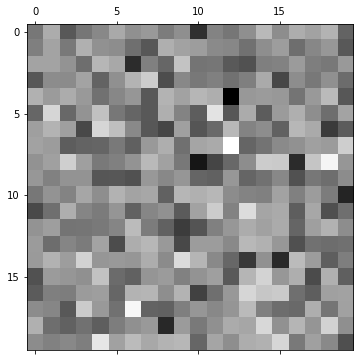

In [10]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))

batch = dataset.get_batch()

plotting.plot_image(ax,
                    batch['images'][0, 0].cpu())

# Train

In [11]:
trainer.fit(sleep_net, datamodule = dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name                   | Type             | Params
------------------------------------------------------------
0 | image_encoder          | LocationEncoder  | 660 K 
1 | image_decoder          | ImageDecoder     | 6     
2 | val_detection_metrics  | DetectionMetrics | 0     
3 | test_detection_metrics | DetectionMetrics | 0     
------------------------------------------------------------
660 K     Trainable params
6         Non-trainable params
661 K     Total params
2.644     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [12]:
sleep_net.to(cuda_no);

# Test out a few images

In [13]:
def get_map_estimate(image_encoder, images, background, slen: int, wlen: int = None):
    # return full estimate of parameters in full image.
    # NOTE: slen*wlen is size of the image without border padding

    if wlen is None:
        wlen = slen
    assert isinstance(slen, int) and isinstance(wlen, int)
    # check image compatibility
    border1 = (images.shape[-2] - slen) / 2
    border2 = (images.shape[-1] - wlen) / 2
    assert border1 == border2, "border paddings on each dimension differ."
    assert slen % image_encoder.tile_slen == 0, "incompatible slen"
    assert wlen % image_encoder.tile_slen == 0, "incompatible wlen"
    assert border1 == image_encoder.border_padding, "incompatible border"

    # obtained estimates per tile, then on full image.
    log_images = subtract_bg_and_log_transform(images, background)
    log_image_ptiles = get_images_in_tiles(
        log_images, image_encoder.tile_slen, image_encoder.ptile_slen
    )
    var_params = image_encoder.encode(log_image_ptiles)
    tile_map = image_encoder.max_a_post(var_params)
    
    map_estimate = get_full_params_from_tiles(tile_map, image_encoder.tile_slen)
    
    var_params_flat = rearrange(var_params, "b nth ntw d -> (b nth ntw) d")
    var_params = image_encoder.encode_for_n_sources(var_params_flat, 
                                                    map_estimate['n_sources'].squeeze().unsqueeze(0))
    
    return map_estimate, var_params

In [14]:
sleep_net.train();

for i in range(20): 
    batch = dataset.get_batch()
    
    _ = get_map_estimate(sleep_net.image_encoder,
                         batch['images'].to(device),
                         dataset.background.view(1, 1, 1, 1).to(device), 
                         slen = 10)
    

In [15]:
sleep_net.image_encoder.eval(); 

In [16]:
batch = dataset.get_batch()
tmp = batch['images'].to(device)
map_est_sleep, _ = get_map_estimate(sleep_net.image_encoder,
                                 tmp,
                                 dataset.background.view(1, 1, 1, 1).to(device), 
                                 slen = 10)

In [17]:
(batch['n_sources'].squeeze() == map_est_sleep['n_sources'].squeeze()).float().mean()

tensor(0.9375, device='cuda:6')

# Deblending experiment

In [20]:
def get_e_nsources(var_params): 
    probs = var_params['n_source_log_probs'].exp()
    e_nsources = probs[:, 1] + 2 * probs[:, 2]
    return(e_nsources)

In [21]:
def deblend_at_delta(delta): 
    dataset.batch_size = 400
    batch = dataset.get_batch()
    
    n_sources = batch['n_sources'] * 0 + 2
    # fluxes = dataset.image_prior._draw_pareto_maxed(batch["fluxes"].shape)
    fluxes = batch['fluxes'] * 0 + 5000
    
    locs = batch['locs']
    locs[:, :, :, 0, :] = 0.5 - delta
    locs[:, :, :, 1, :] = 0.5 + delta
    
    images = dataset.image_decoder.render_images(
                n_sources,
                locs,
                batch["galaxy_bools"],
                batch["galaxy_params"],
                fluxes
            )


    background = dataset.make_background(*images.shape)
    images += background
    images = dataset._apply_noise(images)
    
    map_est_sleep, var_params = get_map_estimate(sleep_net.image_encoder,
                                                 images,
                                                 dataset.background.view(1, 1, 1, 1).to(device), 
                                                 slen = 10)
    
    example_image = images[0, 0]
    true_locs = locs[0, 0]
    
    est_locs = map_est_sleep['locs'][0]
    est_prob2 = (map_est_sleep['n_sources'] == 2).float().mean()
    est_e_nsources = get_e_nsources(var_params).mean()
    
    return est_prob2, est_locs, true_locs, example_image, est_e_nsources

In [22]:
delta_vec = np.linspace(0, 0.15, 31)
delta_vec

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 ])

In [23]:
example_images = torch.zeros(len(delta_vec), 20, 20)

true_locs = torch.zeros(len(delta_vec), 2, 2)
est_locs = torch.zeros(len(delta_vec), 2, 2)

est_probs2 = torch.zeros(len(delta_vec))
e_nsources = torch.zeros(len(delta_vec))

for i in range(len(delta_vec)): 
    
    out = deblend_at_delta(delta_vec[i])

    est_probs2[i] = out[0]
    est_locs[i] = out[1]

    true_locs[i] = out[2]
    example_images[i] = out[3]
    e_nsources[i] = out[4]

print(est_probs2)

tensor([0.0250, 0.0325, 0.0350, 0.0400, 0.0275, 0.0550, 0.0525, 0.0600, 0.0450,
        0.0775, 0.0825, 0.1725, 0.4075, 0.6150, 0.8525, 0.9475, 0.9850, 0.9975,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000])


In [24]:
axis_label_size = 20
ticksize = 12
legendsize = 12
markersize = 10
linewidth = 2
titlesize = 18

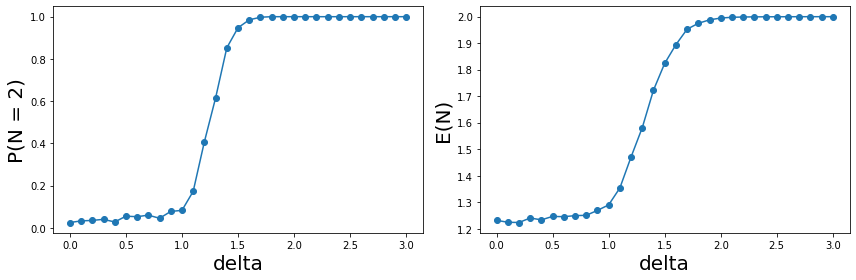

In [31]:
fig, axarr = plt.subplots(1, 2, figsize=(12, 4))

x = delta_vec * sleep_net.image_encoder.tile_slen * 2
axarr[0].plot(x,
              est_probs2, 
              marker = 'o')

axarr[0].set_ylabel('P(N = 2)', fontsize = axis_label_size)
axarr[0].set_xlabel('delta', fontsize = axis_label_size)


axarr[1].plot(x,
              e_nsources.detach().numpy(), 
              marker = 'o')

axarr[1].set_ylabel('E(N)', fontsize = axis_label_size)
axarr[1].set_xlabel('delta', fontsize = axis_label_size)

fig.tight_layout()

fig.savefig('../figures/deblending/summary_statistics.png')


In [28]:
delta_vec_to_plot = [0.04, 0.05, 0.06, 0.07]

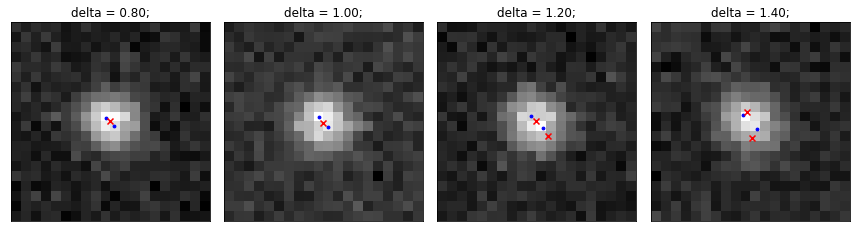

In [32]:
fig, axarr = plt.subplots(1, 4, figsize=(12, 4))

for i in range(len(delta_vec_to_plot)): 
    
    indx = np.argwhere(delta_vec == delta_vec_to_plot[i])[0, 0]
    
    ax = axarr[i]
    plotting.plot_image(ax, example_images[indx])
    ax.scatter(
        true_locs[indx, :, 1] * 10 + 5 - 0.5,
        true_locs[indx, :, 0] * 10 + 5 - 0.5,
        color = 'blue', 
        s = 8
    )
    
    est_locs_i = est_locs[indx, :, :].detach().numpy()
    is_on = est_locs_i[:, 0] != 0
    
    ax.scatter(
        est_locs_i[is_on, 1] * 10 + 5 - 0.5,
        est_locs_i[is_on, 0] * 10 + 5 - 0.5,
        color = 'red',
        marker = 'x',
    )
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_title('delta = {:.2f};'.format(delta_vec[indx] * 10 * 2))
    
    
fig.tight_layout()

fig.savefig('../figures/deblending/example_deblending.png')